In [1]:
import sys
sys.path.extend("./")

In [2]:
import os
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
module_path = os.path.abspath(os.path.join('..'))

In [4]:
sys.path.append(module_path)

In [5]:
from aug_test.mosaic_augmentation import MyMosaicMapper

In [6]:
from common.dataset import register_datasets
from common.config import setup_config

In [7]:
# Define dataset paths
image_root = '../../../dataset/'
json_file = '../../../dataset/train.json'

In [8]:
# Register the dataset
from detectron2.data.datasets.coco import load_coco_json # type: ignore


def register_my_dataset():
    dataset_name = "my_dataset"
    
    # Only register the dataset if it's not already registered
    if dataset_name not in DatasetCatalog.list():
        DatasetCatalog.register(dataset_name, lambda: load_coco_json(json_file, image_root, dataset_name))
        MetadataCatalog.get(dataset_name).set(thing_classes=["General trash", "Paper", "Paper pack", "Metal", 
                                                             "Glass", "Plastic", "Styrofoam", "Plastic bag", 
                                                             "Battery", "Clothing"])


In [9]:
# Register datasets
register_my_dataset()

# Setup config
#cfg = setup_config(training=False)

In [10]:
def visualize_augmentation(dataset_name, num_samples=10, img_size=640):
    dataset_dicts = DatasetCatalog.get(dataset_name)

    for i in range(num_samples):
        # Randomly select an image
        img_dict = random.choice(dataset_dicts)

        # Get original image
        original_image = utils.read_image(img_dict['file_name'], format='BGR')
        
        # Apply MyMapper to visualize mosaic (or normal augmentation)
        augmented_dict = MyMosaicMapper(img_dict, dataset_dicts)  # Pass dataset_dicts for mosaic augmentation
        augmented_image = augmented_dict['image'].numpy().transpose(1, 2, 0)
        
        # Scale the original image to range [0, 1] for proper visualization
        original_image = original_image.astype('float32') / 255.0  # Scale to [0, 1]
        
        # Ensure the augmented image is in valid range and convert to proper type
        augmented_image = augmented_image / 255.0  # Scale to [0, 1]
        
        # Convert BGR to RGB for display
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        augmented_image_rgb = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

        # Convert original image to RGB for display
        #original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Ensure the augmented image is in valid range and convert to RGB
        #augmented_image = (augmented_image * 255).astype('uint8')  # Ensure values are in range [0, 255]
        #augmented_image_rgb = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

        # Convert images to proper format for display
        #original_image = (original_image / 255.0).astype('float32')  # Scale to [0, 1]
        #augmented_image = (augmented_image * 255).astype('uint8')  # Ensure it's in valid range
        #augmented_image_rgb = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
            
        # Plot original and augmented images side by side
        plt.figure(figsize=(12, 6))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image_rgb)
        plt.title(f"Original Image {i + 1}")
        plt.axis('off')

        # Augmented image
        plt.subplot(1, 2, 2)
        plt.imshow(augmented_image_rgb)
        plt.title(f"Augmented Image {i + 1}")
        plt.axis('off')

        plt.show()



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



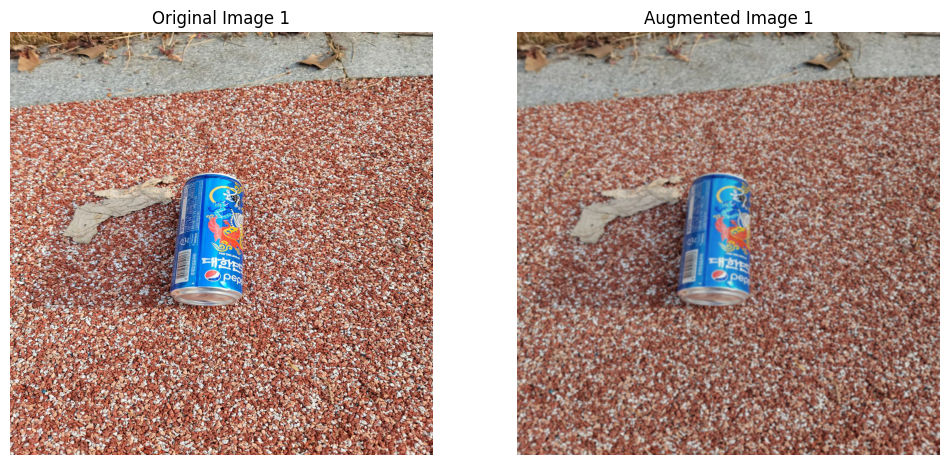

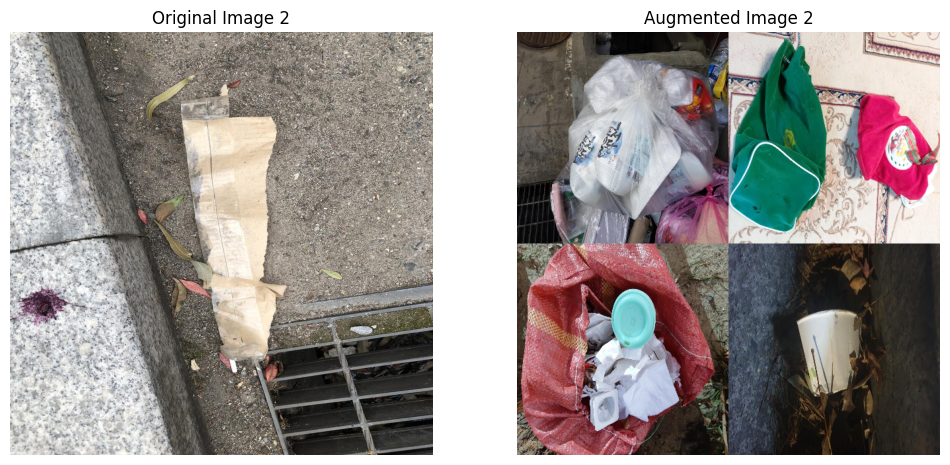

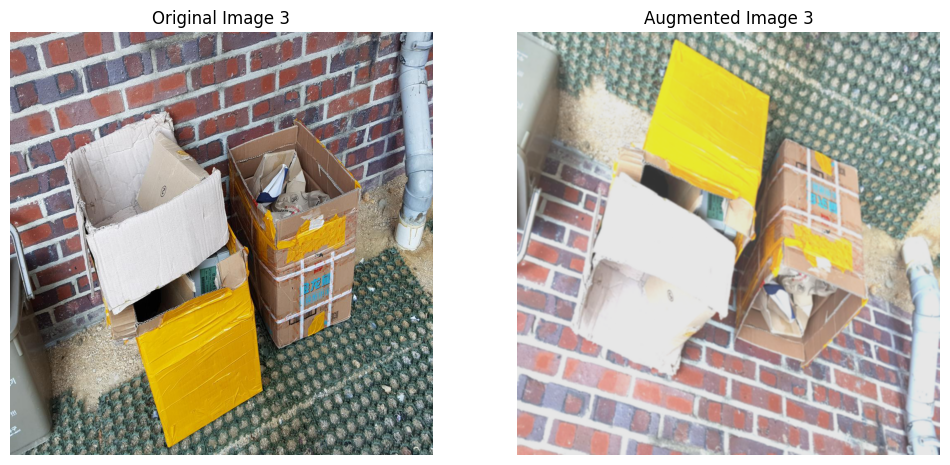

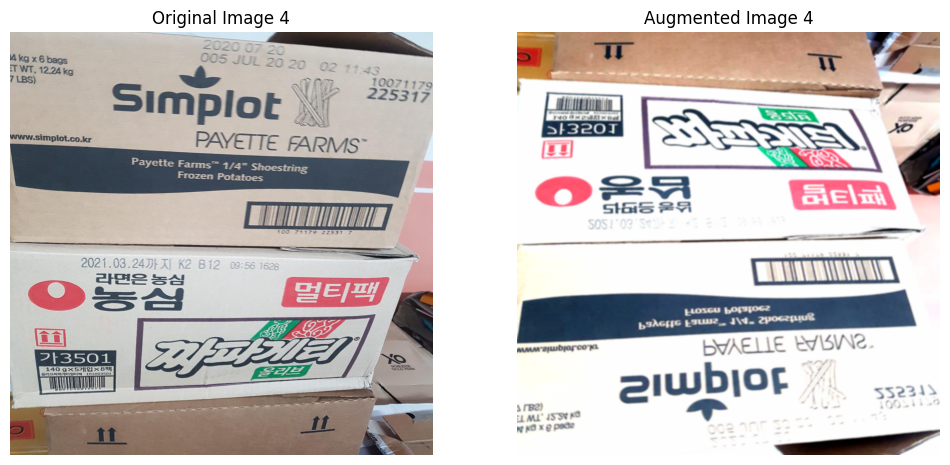

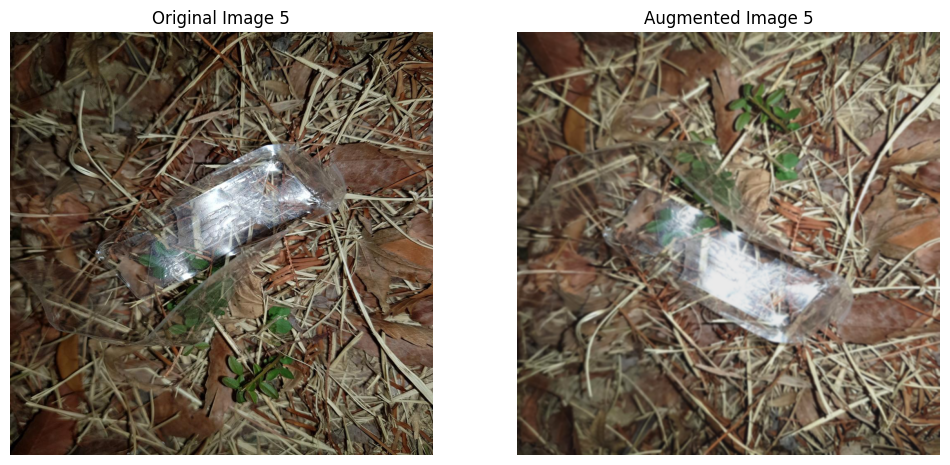

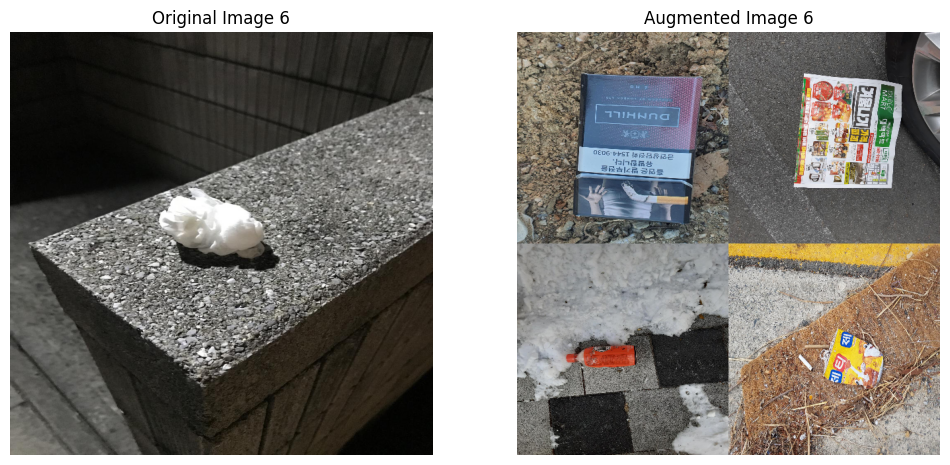

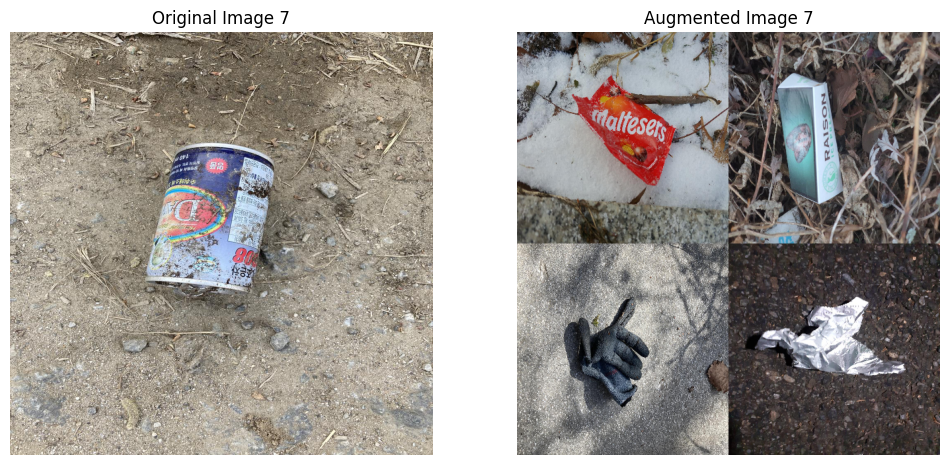

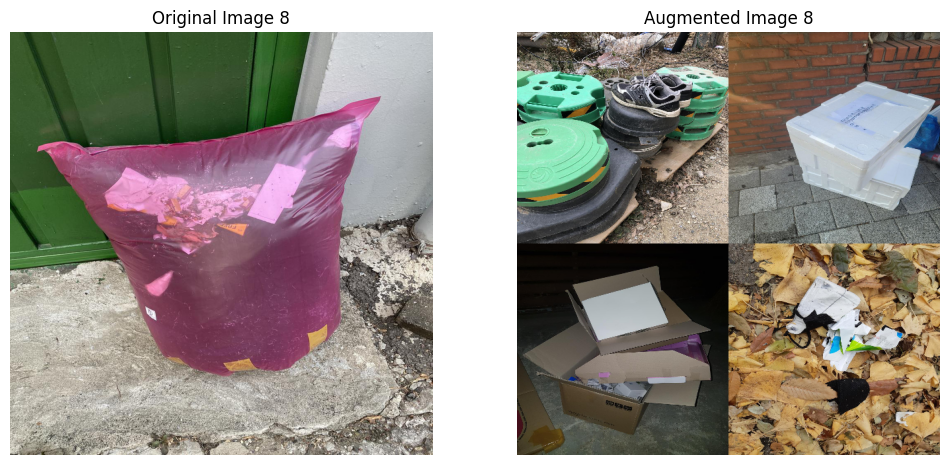

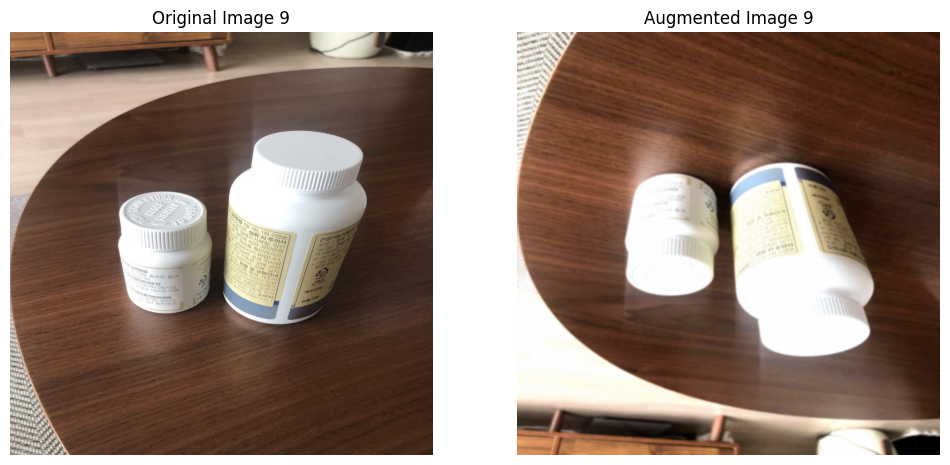

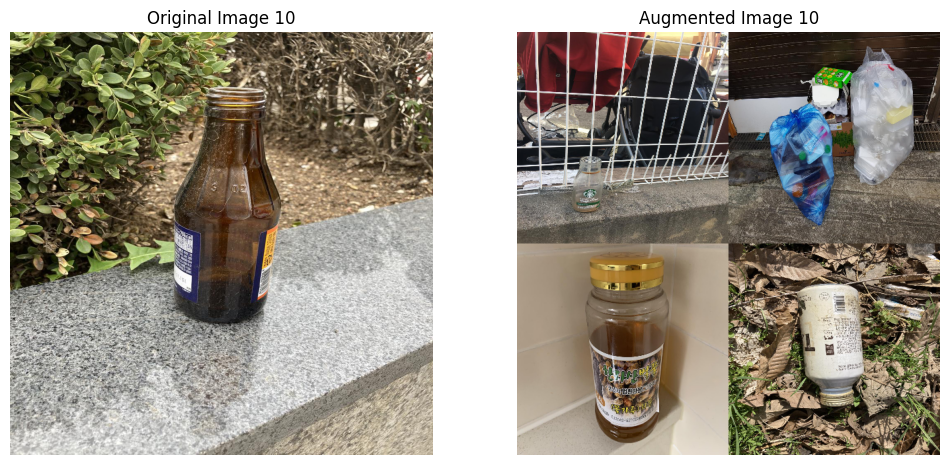

In [12]:
visualize_augmentation('my_dataset', num_samples=10, img_size=640)

In [12]:
from pycocotools.coco import COCO

In [13]:

def visualize_with_bboxes(dataset_dict, coco_annotations):
    """Visualize image with bounding boxes from COCO annotations."""
    
    # Load the image
    img = utils.read_image(dataset_dict['file_name'], format='BGR')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Get the image id from the dataset_dict
    image_id = dataset_dict['image_id']
    
    # Get the annotations for the specific image
    annotations = coco_annotations.loadAnns(coco_annotations.getAnnIds(imgIds=image_id))
    
    # Draw the bounding boxes on the image
    for anno in annotations:
        bbox = anno['bbox']  # [x_min, y_min, width, height]
        x_min, y_min, width, height = [int(v) for v in bbox]
        cv2.rectangle(img, (x_min, y_min), (x_min + width, y_min + height), color=(255, 0, 0), thickness=2)
        
        # Optionally, add category name
        category_id = anno['category_id']
        category_name = coco_annotations.loadCats(category_id)[0]['name']
        cv2.putText(img, category_name, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
# Load COCO annotations
coco_annotations = COCO(json_file)

# Sample dataset dict (replace with actual data retrieval method)
dataset_dicts = DatasetCatalog.get('my_dataset')  # Ensure 'my_dataset' is registered

# Visualize random samples
for i in range(1):  # Change the number as needed
    img_dict = random.choice(dataset_dicts)
    visualize_with_bboxes(img_dict, coco_annotations)

In [15]:
def mosaic_augmentation_with_bboxes(dataset_dicts, img_size=640):
    """Applies Mosaic Augmentation on four random images and adjusts bounding boxes accordingly."""
    
    # Select 4 random images for mosaic
    indices = random.sample(range(len(dataset_dicts)), 4)
    images = []
    bboxes = []
    labels = []
    
    for i, idx in enumerate(indices):
        # Read image
        img_dict = dataset_dicts[idx]
        img = utils.read_image(img_dict["file_name"], format="BGR")
        
        # Resize the image to fit in the mosaic
        h, w, _ = img.shape
        img_resized = cv2.resize(img, (img_size // 2, img_size // 2))
        images.append(img_resized)
        
        # Debug: Print original bounding boxes
        print(f"Original bounding boxes for image {idx}: {img_dict['annotations']}")
        
        # Adjust bounding boxes according to new size and position in mosaic
        scale_x = img_size / (2 * w)  # Scale factor for width
        scale_y = img_size / (2 * h)  # Scale factor for height
        
        for anno in img_dict["annotations"]:
            bbox = anno["bbox"]  # Format: [x_min, y_min, width, height]
            x_min, y_min, width, height = bbox
            
            # Check if bounding box is valid before scaling
            if width <= 0 or height <= 0:
                print(f"Invalid bounding box: {bbox}")
                continue
            
            # Scale the bounding box to the new size
            x_min_scaled = int(x_min * scale_x)
            y_min_scaled = int(y_min * scale_y)
            width_scaled = int(width * scale_x)
            height_scaled = int(height * scale_y)
            
            # Adjust position based on quadrant in the mosaic
            if i == 0:  # Top-left
                pass  # No need to adjust as it is in top-left
            elif i == 1:  # Top-right
                x_min_scaled += img_size // 2
            elif i == 2:  # Bottom-left
                y_min_scaled += img_size // 2
            elif i == 3:  # Bottom-right
                x_min_scaled += img_size // 2
                y_min_scaled += img_size // 2
            
            # Append the adjusted bbox
            bboxes.append([x_min_scaled, y_min_scaled, width_scaled, height_scaled])
            labels.append(anno["category_id"])
    
    # Create an empty canvas for the mosaic
    mosaic_image = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    
    # Place the four images on the canvas
    mosaic_image[:img_size // 2, :img_size // 2, :] = images[0]  # Top-left
    mosaic_image[:img_size // 2, img_size // 2:, :] = images[1]  # Top-right
    mosaic_image[img_size // 2:, :img_size // 2, :] = images[2]  # Bottom-left
    mosaic_image[img_size // 2:, img_size // 2:, :] = images[3]  # Bottom-right
    
    return mosaic_image, bboxes, labels


In [16]:
def visualize_mosaic_with_bboxes(mosaic_image, bboxes, labels, category_names):
    """Visualizes the mosaic image with bounding boxes."""
    
    # Convert BGR to RGB for visualization
    mosaic_image_rgb = cv2.cvtColor(mosaic_image, cv2.COLOR_BGR2RGB)
    
    # Draw bounding boxes
    for bbox, label in zip(bboxes, labels):
        x_min, y_min, width, height = [int(v) for v in bbox]
        x_max = x_min + width
        y_max = y_min + height
        
        # Ensure that bounding box dimensions are positive
        if width > 0 and height > 0:
            cv2.rectangle(mosaic_image_rgb, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
            
            # Draw the label
            if 0 <= label < len(category_names):  # Check if label is within bounds
                label_text = category_names[label]  # Get the class name
                cv2.putText(mosaic_image_rgb, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
            else:
                print(f"Label {label} is out of bounds for category_names.")
        else:
            print(f'Skipping bbox with non-positive dimensions: ({width}, {height})')
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(mosaic_image_rgb)
    plt.axis('off')
    plt.show()


In [ ]:
dataset_dicts = DatasetCatalog.get('my_dataset')  # Replace with your dataset retrieval method

# Apply mosaic augmentation
mosaic_image, bboxes, labels = mosaic_augmentation_with_bboxes(dataset_dicts)

# Assuming category_names is defined somewhere in your code
category_names = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

# Visualize the mosaic image with bounding boxes
visualize_mosaic_with_bboxes(mosaic_image, bboxes, labels, category_names)
